# This is a grok generated code's approach

In [ ]:
import os
import faiss
import json
import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from pathlib import Path

import matplotlib.pyplot as plt

In [23]:
# Initialize CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

# Directory containing images
image_dir = "images"

# Initialize FAISS index (FlatL2 for cosine similarity after normalization)
dimension = 512  # CLIP ViT-B/32 embedding dimension
index = faiss.IndexFlatL2(dimension)


In [31]:
# Dictionary to store doc_id to index mapping
doc_id_mapping = {}
index_to_doc_id = []

# Process images and generate embeddings
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
embeddings = []

for idx, image_file in enumerate(image_files):
    # Extract doc_id from filename (e.g., doc_id.png -> doc_id)
    doc_id = Path(image_file).stem
    doc_id_mapping[doc_id] = idx
    index_to_doc_id.append(doc_id)
    
    # Load and preprocess image
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt", padding=True)
    
    # Generate embedding
    with torch.no_grad():
        image_embedding = model.get_image_features(**inputs).numpy()
    
    # Normalize embedding for cosine similarity
    image_embedding = image_embedding / np.linalg.norm(image_embedding, axis=1, keepdims=True)
    embeddings.append(image_embedding[0])


The channel dimension is ambiguous. Got image shape (3, 69, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape (3, 140, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape (3, 69, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape (3, 5, 3

In [32]:
# Convert embeddings to numpy array and add to FAISS index
embeddings = np.array(embeddings).astype('float32')
index.add(embeddings)

# Save FAISS index
faiss.write_index(index, "image_embeddings_index.faiss")

# Save doc_id mapping to JSON
with open("doc_id_mapping.json", "w") as f:
    json.dump({"doc_id_to_index": doc_id_mapping, "index_to_doc_id": index_to_doc_id}, f)


In [33]:
# Basic retrieval function
def retrieve_image(query, top_k=1):
    # Process query text
    inputs = processor(text=query, return_tensors="pt", padding=True)
    with torch.no_grad():
        text_embedding = model.get_text_features(**inputs).numpy()
    text_embedding = text_embedding / np.linalg.norm(text_embedding, axis=1, keepdims=True)
    
    # Search FAISS index
    distances, indices = index.search(text_embedding, top_k)
    
    # Retrieve matching doc_ids
    results = [(index_to_doc_id[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    return results


Matching image: 37229d52-c04b-4667-b34b-6a52f61816f0..png, Distance: 1.3959007263183594


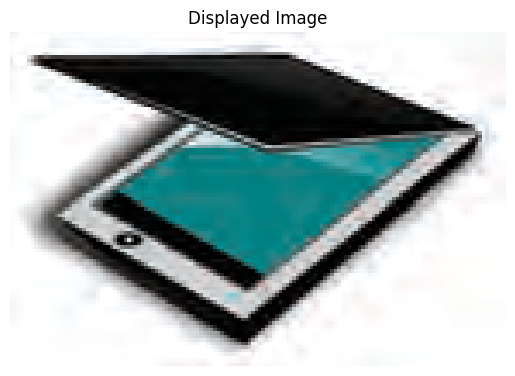

In [51]:

# # Example usage
# if __name__ == "__main__":
query = "difference between router and wifi"
results = retrieve_image(query, top_k=1)
for doc_id, distance in results:
    print(f"Matching image: {doc_id}.png, Distance: {distance}")

image = Image.open(os.path.join(image_dir,f"{doc_id}.png"))

# Plot the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Displayed Image")
plt.show()